In [24]:
import genjax
import jax
import jax.numpy as jnp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import functools
from genjax.generative_functions.distributions import prox
from genjax.generative_functions.distributions.prox import approx_norm_dist, Importance

key = jax.random.PRNGKey(314159)

console = genjax.pretty()

In [25]:
energy = lambda α, x1, x2: α * jnp.sqrt(jnp.abs(x1 - x2))
α = 2.0


@functools.partial(approx_norm_dist, Importance(1000, None))
@prox.unnorm.lang
@genjax.builtin.lang
def approx_dist(α):
    x1 = genjax.normal(1.0, 10.0) @ "x1"
    x2 = genjax.normal(1.0, 10.0) @ "x2"
    genjax.prox.score(energy(α, x1, x2))
    return x1, x2


approx_dist

ApproximateNormalizedDistribution
├── unnorm_fn
│   └── UnnormalizedMeasureFunction
│       └── gen_fn
│           └── BuiltinGenerativeFunction
│               └── source
│                   └── PytreeClosure
│                       ├── callable
│                       │   └── <function approx_dist>
│                       └── environment
│                           └── list
└── custom_q
    └── Importance
        ├── num_particles
        │   └── (const) 1000
        └── proposal
            └── (const) None

In [26]:
jitted = jax.jit(approx_dist.simulate)
jitted(key, (α,))

(Array([2554509582, 3523146368], dtype=uint32), DistributionTrace(...))

In [27]:
%%time
key, tr = jitted(key, (α,))
tr.get_score()

CPU times: user 1.08 ms, sys: 1.2 ms, total: 2.28 ms
Wall time: 657 µs


Array(10.401157, dtype=float32)

In [28]:
tr

DistributionTrace
├── gen_fn
│   └── ApproximateNormalizedDistribution
│       ├── unnorm_fn
│       │   └── UnnormalizedMeasureFunction
│       │       └── gen_fn
│       │           └── BuiltinGenerativeFunction
│       │               └── source
│       │                   └── PytreeClosure
│       │                       ├── callable
│       │                       │   └── <function approx_dist>
│       │                       └── environment
│       │                           └── list
│       └── custom_q
│           └── Importance
│               ├── num_particles
│               │   └── (const) 1000
│               └── proposal
│                   └── (const) None
├── args
│   └── tuple
│       └──  f32[]
├── value
│   └── TrieChoiceMap
│       └── trie
│           └── Trie
│               ├── :x1
│               │   └── ValueChoiceMap
│               │       └── value
│               │           └──  f32[]
│               └── :x2
│                   └── ValueChoiceMap
│                       └── value
│                           └──  f32[]
└── score
    └──  f32[]

In [6]:
xs = np.arange(-10.0, 10.0, 0.05)
mx, my = np.meshgrid(xs, xs)
ys = energy(α, mx, my)

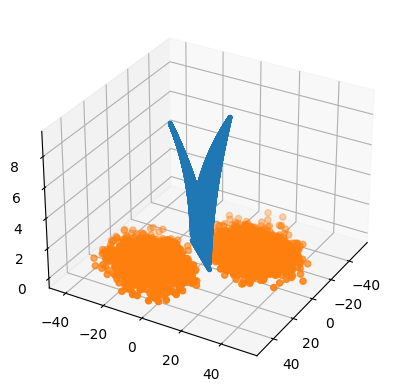

In [7]:
%matplotlib inline

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(mx, my, ys, marker=".")
jitted = jax.jit(jax.vmap(approx_dist.simulate, in_axes=(0, None)))
key, sub_keys = genjax.slash(key, 5000)
_, tr = jitted(sub_keys, (α,))
x1_samples = tr.get_retval()["x1"]
x2_samples = tr.get_retval()["x2"]
ax.scatter(x1_samples, x2_samples, np.zeros(len(x1_samples)))
ax.view_init(30, 30)

plt.show()